In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand
import pickle as pk
from tqdm import tqdm
import os

In [8]:
def metropolis(config,T): # config 를 온도 T에 맞춤 : external field = 0 
    N = len(config)
    for i in range(N):
        for j in range(N):
            dE=2.*config[i,j]*(config[(i-1)%N,j%N]+config[(i+1)%N,j%N]+config[i%N,(j+1)%N]+config[i%N,(j-1)%N])
            if rand()<np.exp(-dE/T):
                config[i,j]*=-1
    return config

def energy(config):# 에너지 계산 : H = - sum Si*Sj.
    N = len(config)
    E=0.
    for i in range(N):
        for j in range(N):
            E -= config[i,j]*(config[(i-1)%N,j%N]+config[(i+1)%N,j%N]+config[i%N,(j+1)%N]+config[i%N,(j-1)%N])/(N**2)
    return E/2
    

def auto_correlation(mag,time_inter,sample_size):
    
    ## input 
    ## config = (Spin array , Samples) 
    ## time interval = (int)
    
    autocorrelation = 0.
    C_ave = 0.
    
    for step in range(sample_size - time_inter):
    
        C_ave += mag[step]/(sample_size - time_inter) ### Sum[(X) / (N-k)]
    
    for step in range(sample_size - time_inter):
    
        C_T = mag[step+time_inter]
    
        C_0 = mag[step]
        
        autocorrelation += (C_0 - C_ave) * (C_T - C_ave) / (sample_size - time_inter)
        
    return autocorrelation

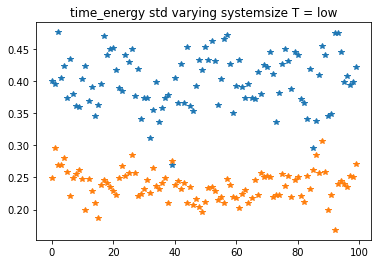

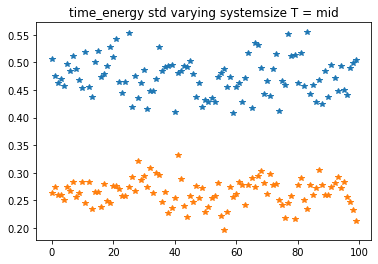

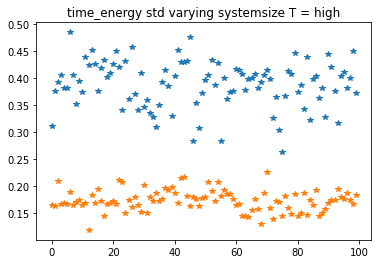

In [5]:
# check steady state##

N_arr = [5,10]
ens = 50
T=np.arange(3.5,2.1,-0.1)


eq_T=100
E_arr = np.zeros((len(T),eq_T,ens,len(N_arr)))


for n,N in enumerate(N_arr):
    for en in range(ens):
        config = np.random.choice((-1,1),size = (N,N))
        
        for i,t in enumerate(T):
            for j in range(eq_T):# equali- time
                config = metropolis(config,t)
                E_arr[i,j,en,n] = energy(config)
                
                
std_E_arr = np.std(E_arr,axis = 2)                
plt.title('time_energy std varying systemsize T = low')
plt.plot(range(eq_T),std_E_arr[-1,:,:],'*')
plt.savefig('save/check steady state_T_low.svg')
plt.show()

plt.title('time_energy std varying systemsize T = mid')
plt.plot(range(eq_T),std_E_arr[10,:,:],'*')
plt.savefig('save/check steady state_T_Tc.svg')
plt.show()

plt.title('time_energy std varying systemsize T = high')
plt.plot(range(eq_T),std_E_arr[0,:,:],'*')
plt.savefig('save/check steady state_T_high.svg')
plt.show()

## 결론 T = Tc 근처에서 fluctuation 크다.

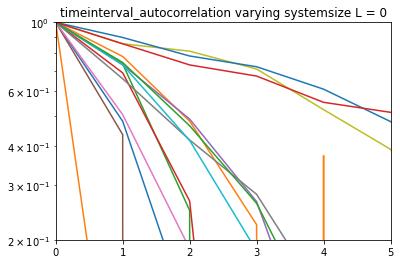

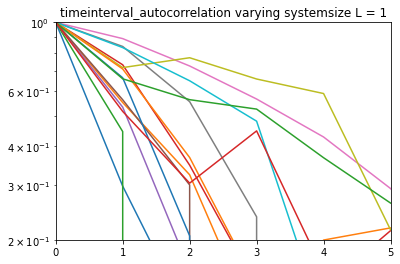

In [11]:
## calculate auttocorrelation ##

N_arr = [5,10]
ens = 5
T=np.arange(3.5,2.1,-0.1)
eq_T=500
save_T=20
M_arr = np.zeros((len(T),save_T,ens,len(N_arr)))


for n,N in enumerate(N_arr):
    for en in range(ens):
        config = np.random.choice((-1,1),size = (N,N))
        
        for i,t in enumerate(T):
            for _ in range(eq_T):# equali- time
                config = metropolis(config,t)

            for j in range(save_T):# clac- time
                config  = metropolis(config,t)
                M_arr[i,j,en,n] = np.average(config)
                

ave_M_arr = np.average(M_arr,axis = 2) 

for N_idx, N in enumerate(N_arr):
    for i,t in enumerate(T):
        m = ave_M_arr[i,:,N_idx]
        for j in range(save_T):
            
            autocorrelation_arr[j,i] = auto_correlation(m,j,save_T)
        
    plt.title('timeinterval_autocorrelation varying systemsize L = %d'%N)
    plt.plot(range(save_T),autocorrelation_arr/autocorrelation_arr[0])
    plt.yscale('log')
    plt.ylim(0.2,1)
    plt.xlim(0,5)
    plt.savefig('save/autocorrelation_L%d.svg'%N)
    plt.show()


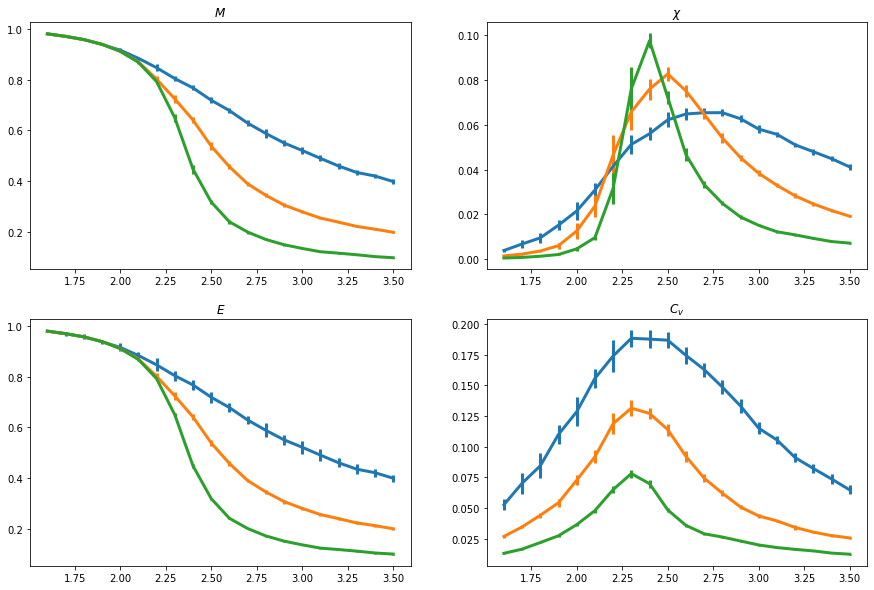

In [18]:
N_arr = [5,10,20]
T=np.arange(3.5,1.5,-0.1)

eq_T=1000
save_T=1000

ens = 20

plt.figure(figsize = (15,10))

M_arr = np.zeros((len(T),save_T,ens))
M2_arr = np.zeros((len(T),save_T,ens))
E_arr = np.zeros((len(T),save_T,ens))
E2_arr = np.zeros((len(T),save_T,ens))

for n,N in enumerate(N_arr):
    for en in range(ens):
        config = np.random.choice((-1,1),size = (N,N))
        
        for i,t in enumerate(T):
            for _ in range(eq_T):# equali- time
                config = metropolis(config,t)

            for j in range(save_T):# clac- time
                config  = metropolis(config,t)
                
                M_arr[i,j,en] = abs(np.average(config))
                M2_arr[i,j,en] = M_arr[i,j,en]**2
                E_arr[i,j,en] = energy(config)
                E2_arr[i,j,en] = E_arr[i,j,en]**2
                
    M = np.average(M_arr , axis = 1)
    M2 = np.average(M2_arr , axis = 1)
    E = np.average(E_arr,axis =1)
    E2 = np.average(E2_arr,axis =1)
    
    X = np.sqrt(N) * (M2 - M**2) / (T[:,np.newaxis])
    C = N * (E2 - E**2) / (T[:,np.newaxis]**2)
    
    ave_M = np.average(M,axis =1)
    std_M = np.std(M,axis = 1)
    
    ave_E = np.average(M,axis = 1)
    std_E = np.std(E,axis = 1)
    
    ave_X = np.average(X,axis =1)
    std_X = np.std(X,axis =1)
    
    ave_C = np.average(C,axis =1)
    std_C = np.std(C,axis =1)
    
    
    
    np.savez('save/2d_Ising_L%d'%N, M =  M, M2 = M2, X = X , C = C)
    
    plt.subplot(2,2,1)
    plt.title('$M$')
    plt.errorbar(T,ave_M,1.96 * std_M / np.sqrt(N),lw=3)
    
    plt.subplot(2,2,2)
    plt.title(r'$\chi$')
    plt.errorbar(T,ave_X,1.96 * std_X / np.sqrt(N),lw=3)
    
    plt.subplot(2,2,3)
    plt.title('$E$')
    plt.errorbar(T,ave_E,1.96 * std_E / np.sqrt(N),lw=3)
    
    plt.subplot(2,2,4)
    plt.title(r'$C_v$')
    plt.errorbar(T,ave_C,1.96 * std_C / np.sqrt(N),lw=3)
    
plt.savefig('save/2D_Ising.svg')
